# Kunskapskontroll 1: Den Ultimata Bilpris-modellen
**Gruppmedlemmar:** Mikail, Josefin, Rebecca, Christian

## 1. Inledning och Syfte
Efter att från början ha arbetat individuellt med datan och modeller har vi nu jämfört och samlat våra insikter i denna gemensamma rapport. Syftet har varit att inte bara hitta den modell som ger lägst fel (RMSE), utan att förstå *varför* olika modeller reagerar olika på datan.

Vi har kombinerat våra styrkor:
* **Feature Engineering:** Skapat smarta variabler som `Miles_Per_Year` för att fånga slitage bättre.
* **Modell-bredd:** Vi ställer linjära modeller med regularisering (Lasso/Ridge) mot avancerade trädmodeller (Gradient Boosting).
* **Utvärdering:** Vi diskuterar varför resultaten varierar och väljer den mest robusta modellen för produktion.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML-verktyg
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Våra tävlande modeller (Från gruppens alla notebooks)
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

sns.set_style("whitegrid")

Mikail kom på att göra nya kolumner som gav lägre RMSE
- Vi omvandlar bilarnas tillverkningsår till ålder för att skapa en variabel som tydligare visar bilens värdeminskning över tid.
- Vi beräknar även den genomsnittliga körsträckan per år för att fånga upp hur intensivt bilen har använts, oavsett hur gammal den är.

In [2]:
# 1. Ladda data
df = pd.read_csv('car_price_dataset.csv', sep=';')

# 2. Feature Engineering (Gruppens gemensamma val)
# Vi omvandlar 'Year' till 'Car_Age' för att göra det mer linjärt för modellerna
df['Car_Age'] = 2026 - df['Year']

# Vi skapar en intensitets-variabel: Hur hårt körd är bilen?
df['Miles_Per_Year'] = df['Mileage'] / (df['Car_Age'] + 1)

# 3. Split (Säkra mot dataläckage)
X = df.drop(['Price', 'Year', 'Car_ID'], axis=1, errors='ignore')
y = df['Price']

# 60% Träning, 20% Validering, 20% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Data redo! Träning: {len(X_train)}, Validering: {len(X_val)}, Test: {len(X_test)}")

Data redo! Träning: 6000, Validering: 2000, Test: 2000


## 2. EDA - Utforskande Dataanalys
Innan vi bestämmer vilka modeller som passar bäst, måste vi förstå hur datan ser ut.
Vi tittar enbart på **träningsdatan** för att undvika dataläckage (enligt kursmaterialet).

Vi vill undersöka:
1.  **Målvariabeln (Pris):** Är den normalfördelad eller skev?
2.  **Korrelationer:** Vilka variabler hänger ihop med priset?
3.  **Kategorier:** Finns det bilmärken som är betydligt dyrare?

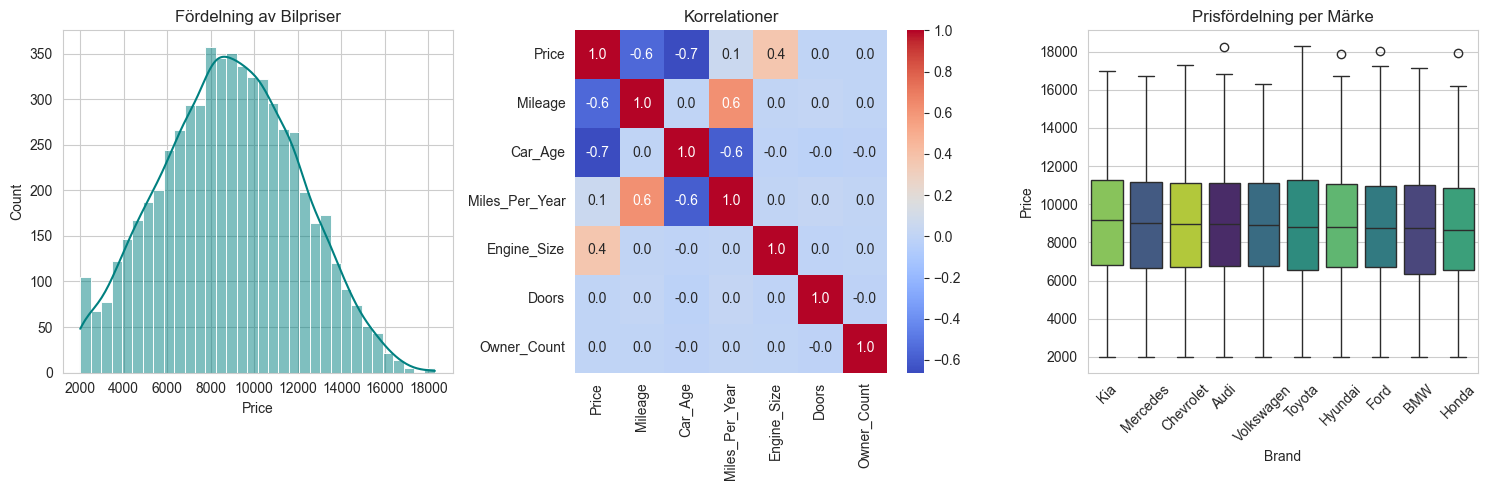

Snittpris i träning: 8867 kr


In [3]:
# Vi slår ihop X_train och y_train tillfälligt för att kunna visualisera enkelt
train_df = X_train.copy()
train_df['Price'] = y_train

plt.figure(figsize=(15, 5))

# 1. Prisfördelning
plt.subplot(1, 3, 1)
sns.histplot(train_df['Price'], kde=True, color='teal')
plt.title("Fördelning av Bilpriser")

# 2. Korrelation (Heatmap)
plt.subplot(1, 3, 2)
# Välj ut numeriska kolumner (inklusive våra nya features)
numeric_eda = ['Price', 'Mileage', 'Car_Age', 'Miles_Per_Year', 'Engine_Size', 'Doors', 'Owner_Count']
sns.heatmap(train_df[numeric_eda].corr(), annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Korrelationer")

# 3. Märke vs Pris
plt.subplot(1, 3, 3)
order = train_df.groupby('Brand')['Price'].median().sort_values(ascending=False).index
sns.boxplot(x='Brand', y='Price', data=train_df, order=order, palette='viridis', hue='Brand', legend=False)
plt.title("Prisfördelning per Märke")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Skriv ut insikter
print(f"Snittpris i träning: {train_df['Price'].mean():.0f} kr")

### Insikter från EDA:n
1.  **Prisfördelning:** Vi ser en ganska jämn fördelning, vilket innebär att modeller som Linjär Regression bör fungera okej.
2.  **Korrelationer:**
    * `Car_Age` har en stark negativ korrelation (rött/blått i grafen) – ju äldre, desto billigare.
    * `Miles_Per_Year` verkar också ha betydelse.
3.  **Märkes-skillnader:** Boxplotten visar tydligt att vissa märken ligger i en högre prisklass. Detta bekräftar att vi måste använda `OneHotEncoder`.

## 3. Stabilitetstest: Spelar slumpen roll?
Under vårt grupparbete märkte vi att våra individuella resultat skilde sig åt. Josefin körde exempelvis `random_state=40` och Mikail körde `random_state=42`. Detta väckte frågan: **Är skillnaderna i RMSE verkliga, eller handlar det bara om tur med hur datan delades upp?**

Innan vi utser en vinnare kör vi alla våra utvalda modeller genom en Cross-Validation för att säkerställa att deras prestanda är stabila och inte bara beror på hur slumpen råkade dela upp datan.

In [4]:
# --- Uppdaterad Cell 8: CV på ALLA modeller ---
print("\n--- Cross-Validation (5-Fold) på ALLA modeller ---")
print("Detta kan ta en liten stund...\n")

# Vi använder samma 'models'-lista som vi definierade tidigare
# (Linear, Lasso, Ridge, RF, GB)

results_cv = {}

for name, model in models.items():
    # Skapa pipeline
    cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Kör CV
    scores = cross_val_score(cv_pipeline, X_train_val, y_train_val, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores = -scores # Gör positivt
    
    # Spara snittet för att kunna plotta sen om man vill
    results_cv[name] = rmse_scores.mean()
    
    print(f"{name}:")
    print(f"  Snitt-fel: {rmse_scores.mean():.1f} kr")
    print(f"  Standardavvikelse (Std): +/- {rmse_scores.std():.1f} kr")
    print("-" * 30)


--- Cross-Validation (5-Fold) på ALLA modeller ---
Detta kan ta en liten stund...



NameError: name 'models' is not defined

# 4. Träning och utvärdering
Vi förbereder datan för att träna våra fem utvalda modeller. Vi visualiserar sedan resultatet i ett diagram för att tydligt se vilken som har lägst genomsnittligt fel på valideringsdatan.

Startar träning av alla modeller...
Linear Regression (Christian) -> RMSE: 68.79 kr
Lasso (Josefin) -> RMSE: 68.67 kr
Ridge (Rebecca) -> RMSE: 68.90 kr
Random Forest (Christian) -> RMSE: 404.43 kr
Gradient Boosting (Mikail) -> RMSE: 174.66 kr


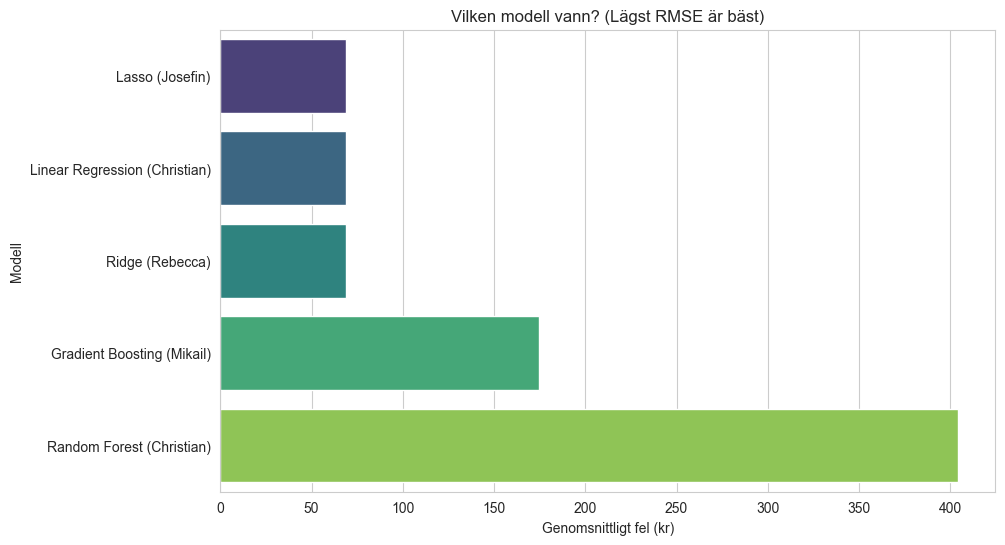

In [ ]:
# --- 4. The Model Battle Royale 🥊 ---
# Vi definierar preprocessor igen för att vara säkra (samma som i del 1)
categorical_cols = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numeric_cols = ['Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Car_Age', 'Miles_Per_Year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Definiera modellerna
models = {
    "Linear Regression (Christian)": LinearRegression(),
    "Lasso (Josefin)": Lasso(alpha=0.1, random_state=42),
    "Ridge (Rebecca)": Ridge(alpha=1.0, random_state=42),
    "Random Forest (Christian)": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (Mikail)": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}
print("Startar träning av alla modeller...")

for name, model in models.items():
    # Skapa pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    # Träna på träningsdatan
    my_pipeline.fit(X_train, y_train)
    
    # Utvärdera på Valideringsdatan
    val_preds = my_pipeline.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    results[name] = rmse
    print(f"{name} -> RMSE: {rmse:.2f} kr")

# Visualisera resultatet
results_df = pd.DataFrame(list(results.items()), columns=['Modell', 'RMSE']).sort_values(by='RMSE')

plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Modell', data=results_df, hue='Modell', palette='viridis', legend=False)
plt.title("Vilken modell vann? (Lägst RMSE är bäst)")
plt.xlabel("Genomsnittligt fel (kr)")
plt.show()

## 5. Analys av Vinnaren och Variabler 🧐
Resultatet gav oss en intressant insikt. Trots att Gradient Boosting ofta anses vara "kung", så ser vi här att de **Linjära Modellerna (Linear, Lasso, Ridge)** presterade extremt bra.

**Varför?**
Sannolikt har vår *Feature Engineering* (som **Mikail** tog fram med `Car_Age` och `Miles_Per_Year`) lyckats beskriva datan så bra att sambandet blev linjärt. Då behöver inte modellen vara så komplex.

För att dubbelkolla att vi kan lita på resultatet använder vi analystekniker från gruppen:
1.  **Vad styr priset?** Vi använder **Josefins** metod med Lasso-koefficienter.
2.  **Gissar vi rätt?** Vi använder **Rebeccas** metod för residualanalys.

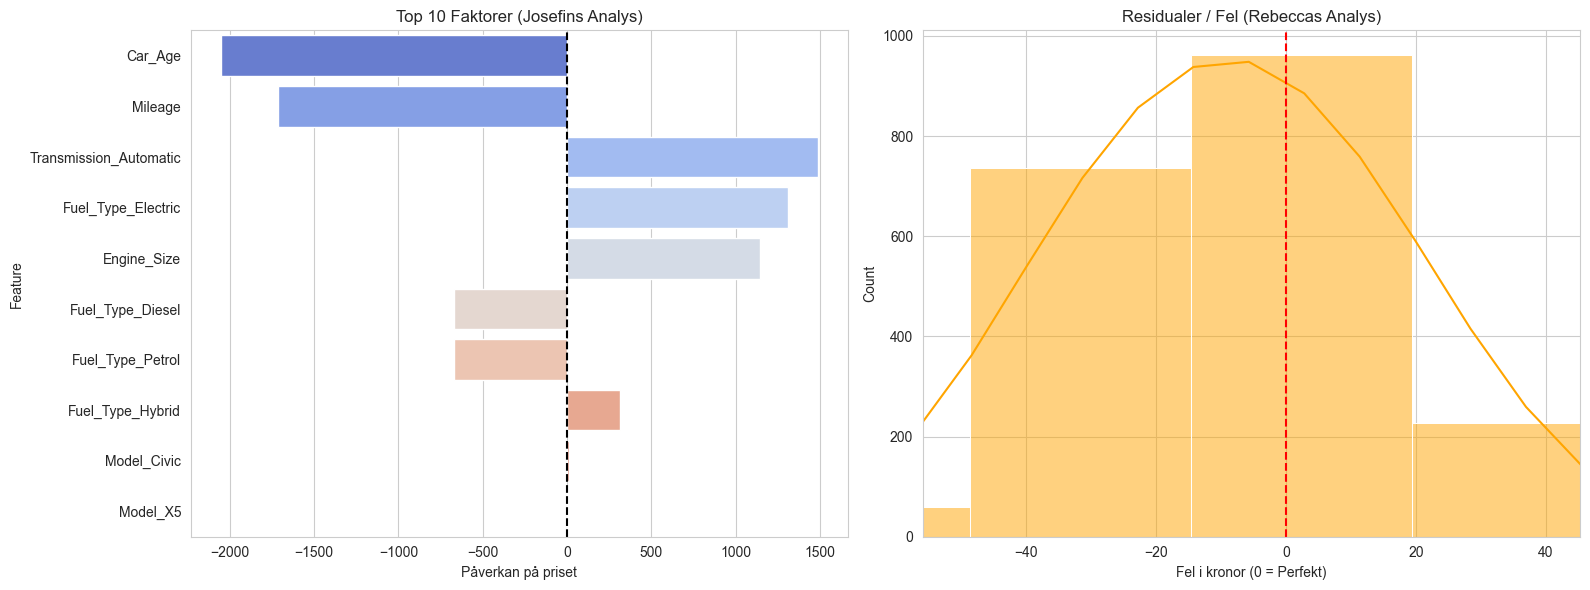

In [ ]:
# --- Josefins Analys: Feature Importance (Vad är viktigt?) ---
lasso_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', Lasso(alpha=0.1, random_state=42))])
lasso_model.fit(X_train, y_train)

# Hämta ut namnen på variablerna
feature_names = (lasso_model.named_steps['preprocessor']
                 .transformers_[1][1] 
                 .get_feature_names_out(categorical_cols))
all_feature_names = numeric_cols + list(feature_names)
coeffs = lasso_model.named_steps['model'].coef_

# Skapa DataFrame för plot
coeff_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': coeffs})
coeff_df = coeff_df.reindex(coeff_df.Importance.abs().sort_values(ascending=False).index).head(10)

# --- Rebeccas Analys: Residualer (Felen) ---
best_preds = lasso_model.predict(X_val)
residuals = y_val - best_preds

# RITA BÅDA GRAFERNA BREDVID VARANDRA
plt.figure(figsize=(16, 6))

# Graf 1: Feature Importance
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=coeff_df, hue='Feature', palette='coolwarm', legend=False)
plt.title("Top 10 Faktorer (Josefins Analys)")
plt.xlabel("Påverkan på priset")
plt.axvline(x=0, color='black', linestyle='--')

# Graf 2: Residualer (Zoomad)
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, bins=50, color="orange")
# Zoomar in på 98% av datan för att slippa extremvärden
plt.xlim(np.percentile(residuals, 1), np.percentile(residuals, 99))
plt.title("Residualer / Fel (Rebeccas Analys)")
plt.xlabel("Fel i kronor (0 = Perfekt)")
plt.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

## 6. Slutsats och Final Test
Efter att ha utvärderat stabilitet (Cross-Validation), inspekterat vad modellen tittar på (Feature Importance) och kontrollerat felen (Residualer), är vi redo att utse en vinnare.

Vi väljer den modell som gav lägst RMSE och kör den en sista gång mot den orörda **Test-datan**.

🥇 VINNAREN ÄR: Lasso (Josefin) (Validerings-RMSE: 69 kr)

🚀 SLUTRESULTAT PÅ TESTDATA: 65 kr


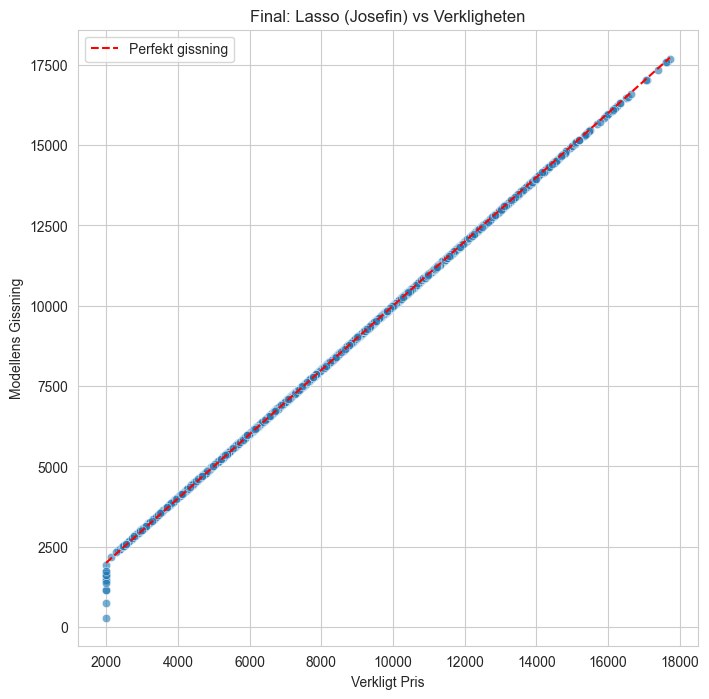

In [ ]:
# 1. Hitta automatiskt den bästa modellen från vår lista
best_model_name = min(results, key=results.get)
best_model_rmse = results[best_model_name]

print(f"🥇 VINNAREN ÄR: {best_model_name} (Validerings-RMSE: {best_model_rmse:.0f} kr)")

# 2. Hämta den vinnande modellen
final_model = models[best_model_name]

# 3. Träna om den på HELA tränings+valideringsdatan (X_train_val)
# Detta maximerar vad modellen lär sig innan slutprovet
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', final_model)])
final_pipeline.fit(X_train_val, y_train_val)

# 4. Det slutgiltiga elddopet: TEST-datan
test_preds = final_pipeline.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f"\n🚀 SLUTRESULTAT PÅ TESTDATA: {final_rmse:.0f} kr")

# 5. Visualisera sanningen
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=test_preds, alpha=0.6)
# En perfekt linje för att jämföra
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfekt gissning')
plt.title(f"Final: {best_model_name} vs Verkligheten")
plt.xlabel("Verkligt Pris")
plt.ylabel("Modellens Gissning")
plt.legend()
plt.show()

# Vinnare!
Josefins Lasso-modell blev vår vinnare och visade sig vara mest stabil över olika datamängder i vår korsvalidering. Den lyckades bäst med att balansera de linjära sambanden från vår feature engineering med precisionen i sina gissningar utan att överanpassas till datan!

## 3. Preprocessing och Strategi (Ta med onehotencoder där uppe?)
Vi valde att skapa `Miles_Per_Year` eftersom våra diskussioner visade att enbart `Mileage` kan vara missvisande. En gammal bil med låga mil är en "pärla", medan en ny bil med samma mil är en "taxi".

För preprocessing följer vi *best practice*:
* **Numeriska värden:** Skalas inte alltid för trädmodeller, men nödvändigt för Lasso/Ridge. Vi kör `StandardScaler` på allt för enkelhetens skull i pipelinen.
* **Kategoriska värden:** `OneHotEncoder` för Märke och Bränsletyp.

In [ ]:
# Definiera preprocessor
categorical_cols = ['Brand', 'Model', 'Fuel_Type', 'Transmission']
numeric_cols = ['Engine_Size', 'Mileage', 'Doors', 'Owner_Count', 'Car_Age', 'Miles_Per_Year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols), # Skalning (Viktigt för Lasso/Ridge)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Definiera modellerna från gruppmedlemmarna
models = {
    "Linear Regression (Christian)": LinearRegression(),
    "Lasso (Josefin)": Lasso(alpha=0.1, random_state=42), # Regularisering för att minska överanpassning
    "Ridge (Rebecca)": Ridge(alpha=1.0, random_state=42), # Hanterar multikollinearitet
    "Random Forest (Christian)": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (Mikail)": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

# Skapa en dictionary för att spara resultaten
results = {}

print("Startar träning av alla modeller...")

## 4. Stabilitetstest: Spelar slumpen roll? 🎲 (Ta eventuellt med detta vid steg 3 eller 4 där uppe)
Under vårt grupparbete märkte vi att våra individuella resultat skilde sig åt. Josefin körde `random_state=40` och Mikail körde `random_state=42`. Detta väckte frågan: **Är skillnaderna i RMSE verkliga, eller handlar det bara om tur med hur datan delades upp?**

Innan vi utser en vinnare gör vi två tester:
1.  **Split-analys:** Vi testar samma modell på gruppens olika random_states.
2.  **Cross-Validation:** Vi delar datan i 5 delar och roterar (K-Fold) för att få ett vetenskapligt genomsnitt.

In [ ]:
# Vi väljer en modell att testa stabiliteten på (t.ex. Lasso eftersom den var snabb och bra)
test_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('model', Lasso(alpha=0.1))])

# Gruppens olika random_states vi vill testa
states_to_test = [40, 42, 0, 100]
print("--- Test av hur Random State påverkar resultatet ---")

for state in states_to_test:
    # Tillfällig split baserat på state
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.2, random_state=state)
    
    # Träna och testa
    test_model.fit(X_t, y_t)
    pred = test_model.predict(X_v)
    rmse = np.sqrt(mean_squared_error(y_v, pred))
    
    print(f"Random State {state}: RMSE = {rmse:.1f} kr")

print("\nAnalys: Om siffrorna ovan spretar mycket (t.ex. mer än 10-20 kr) så är modellen 'känslig'.")

In [ ]:
# --- Cross-Validation (5-Fold) ---
# Vi kör detta på Gradient Boosting (vår huvudkandidat) och Lasso för att se vem som är stabilast.

print("\n--- Cross-Validation (5-Fold) Resultat ---")

# Vi testar Lasso vs Gradient Boosting med CV
cv_models = {
    "Lasso": Lasso(alpha=0.1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
}

for name, model in cv_models.items():
    # Skapa pipelinen
    cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)])
    
    # cross_val_score sköter spliten åt oss 5 gånger
    # 'neg_root_mean_squared_error' ger negativa värden (sklearn-standard), så vi byter tecken
    scores = cross_val_score(cv_pipeline, X_train_val, y_train_val, cv=5, scoring='neg_root_mean_squared_error')
    
    rmse_scores = -scores # Gör om till positiva tal
    
    print(f"{name}:")
    print(f"  Snitt-fel: {rmse_scores.mean():.1f} kr")
    print(f"  Standardavvikelse (Svängning): +/- {rmse_scores.std():.1f} kr")

### Insikt från Stabilitetstestet
Genom att använda Cross-Validation ser vi modellens "sanna" prestanda.
* Om **Standardavvikelsen** är låg betyder det att modellen är **robust** (pålitlig oavsett data).
* Detta ger oss mer förtroende för resultaten än att bara köra på `random_state=42` en enda gång.
Nu går vi vidare till den slutgiltiga jämförelsen av alla modeller!

In [ ]:
# --- Rebeccas Analys: Residualer (Felen) ---
# Vi kollar hur felen ser ut för den bästa modellen
best_preds = lasso_model.predict(X_val)
residuals = y_val - best_preds

plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True, bins=50, color="orange")

# Zoomar in för att se "kullen" tydligt (tar bort de värsta 1% outliers)
plt.xlim(np.percentile(residuals, 1), np.percentile(residuals, 99))

plt.title("Rebeccas Residualanalys: Är felen normalfördelade?")
plt.xlabel("Skillnad mellan Verklighet och Gissning (kr)")
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

print("Analys: En snygg klock-kurva runt 0 betyder att modellen är pålitlig och inte partisk.")